## **Rendu TP3 (30/10/2023)**
### **Binome : Linda BELKESSA - Youcef AZOUAOUI (M2 Datascale)**

## **Contenu du Notebook**


> 1. **Part I : Etude non supervisée**
2. **Part II : Etude supervisée sur la tache de série temporelle**
3. **Part III : Etude supervisée sur la tache de classification**

In [2]:
# Import packages
!pip install category_encoders

In [3]:
# Import necessary packages and suppress warnings
import warnings
warnings.filterwarnings('ignore')


# Data Manipulation
import pandas as pd
import numpy as np
import json

# Data Visualization and Display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Manipulating Date and Time
import datetime as dt

# Time Series Manipulation and analysis
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pywt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Time Series Forecasting Models
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

# Supervised classification
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

# Unsupervised learning
from sklearn.cluster import DBSCAN
from re import X
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from collections import Counter


- Récupération du dataset issu de la partie précédente du projet

In [4]:
#Chargement des données depuis URL Github
dataset = pd.read_csv("https://raw.githubusercontent.com/Lynda-Starkus/ML-PROJ/master/dataset/cleaned_data.csv")
raw_data = pd.read_csv("https://raw.githubusercontent.com/Lynda-Starkus/ML-PROJ/master/dataset/tornados.csv")
dataset.head()

,Unnamed: 0,om,st,mag,inj,loss,wid,len,ns
0,1950-10-02 03:00:00,192,OK,1.0,0,50000.0,10,15.8,1
1,1950-10-09 08:15:00,193,NC,3.0,3,500000.0,880,2.0,1
2,1950-11-20 08:20:00,195,KY,2.0,0,500000.0,10,0.1,1
3,1950-11-20 10:00:00,196,KY,1.0,0,500000.0,10,0.1,1
4,1950-11-20 13:30:00,197,MS,1.0,3,50000.0,37,2.0,1


# **Partie I : Etude non supervisée**


In [5]:
data = raw_data.copy()
X_train = data[data.columns[10:]]
X_train = X_train.dropna()
clustering = DBSCAN(eps=12.5, min_samples=100).fit(X_train)
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
-1,36174
1,2964
0,2081
2,298


In [6]:
data.columns

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'datetime_utc', 'st',
       'stf', 'mag', 'inj', 'fat', 'loss', 'slat', 'slon', 'elat', 'elon',
       'len', 'wid', 'ns', 'sn', 'f1', 'f2', 'f3', 'f4', 'fc'],
      dtype='object')

In [7]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(X_train, clustering.labels_)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.6355516859166283


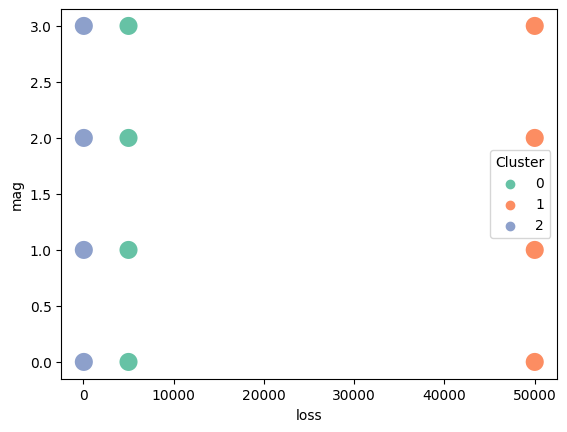

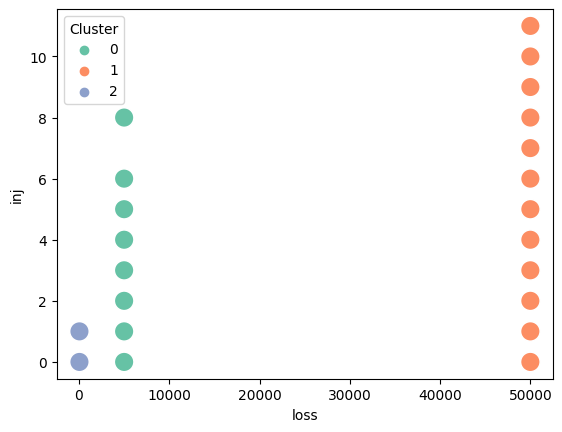

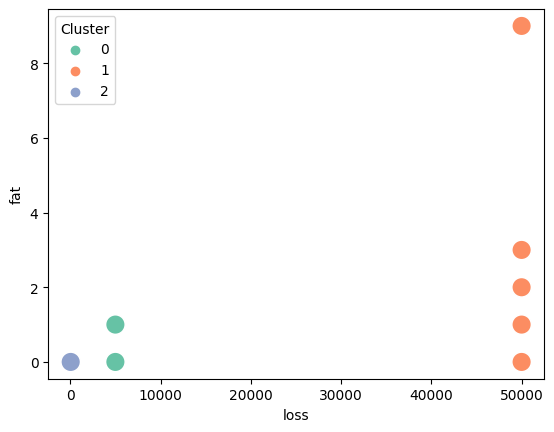

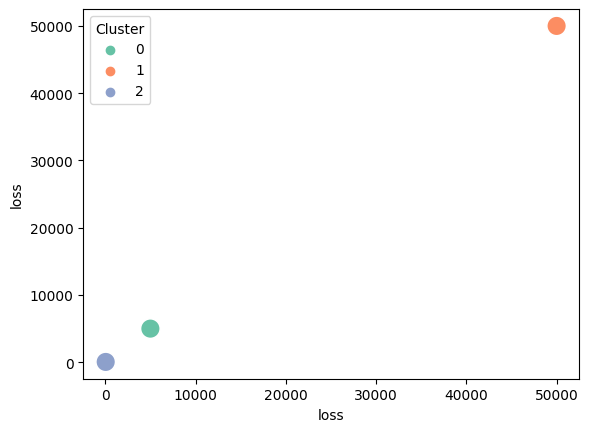

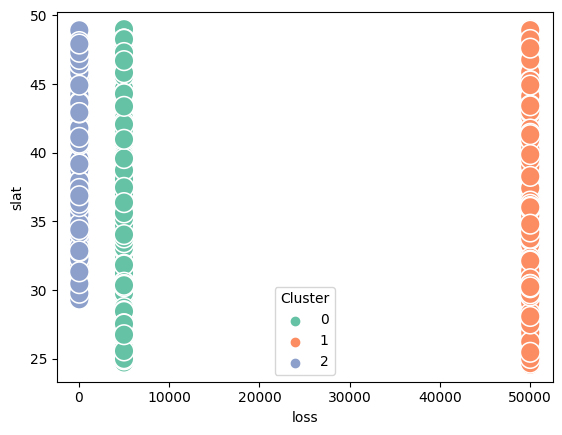

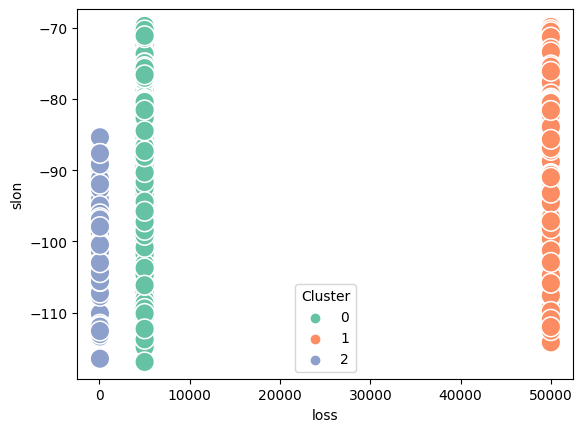

In [8]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

cols = ['mag', 'inj', 'fat', 'loss', 'slat', 'slon']

num = 1

for j in cols:
  fig = plt.figure(num)
  sns.scatterplot(x='loss', y=j, data=DBSCAN_dataset[DBSCAN_dataset['Cluster'] != -1],
              hue='Cluster', palette='Set2', s=200)
  num += 1

fig.show()

- Nous avons supprimer la colonne "st" car nous ne pouvons pas normaliser une variable catégorique (ou utiliser PCA dessus), et nous ne pouvons pas utiliser les encodeurs suivant :
 - Le label encoding n'est pas utilisable car ça donnera des differences illogique et instable entre les états.
  - Le "one-hot-encoding" n'est pas utilisable car nous avons 52 valeurs unique dans l'attribut, ce qui nous obligera a creer 52 attributs, qui causera un probléme de dimensionnalité.
  - Le target encoding n'est pas utilisable car il n y'a pas de target dans la problématique non supervisée.

In [9]:
data = dataset.copy()
#Encodage de la date a un entier avec l'expression suivante : YYYYMMDDHHmmSS + Supression de "st"
data[data.columns[0]]=data[data.columns[0]].str.replace(r'[- :]', '', regex=True)

data_nost=data.drop(columns=["st"])
data_nost.head()

#Utilisation de la normalisation Min-Max sur notre dataset.
scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data_nost)

print(data_scaled)

[[1.24646568e-03 3.07034959e-04 2.00000000e-01 ... 2.18531469e-03
  6.73199830e-02 0.00000000e+00]
 [1.25624412e-03 3.08642471e-04 6.00000000e-01 ... 1.92307692e-01
  8.52151683e-03 0.00000000e+00]
 [1.41017056e-03 3.11857497e-04 4.00000000e-01 ... 2.18531469e-03
  4.26075841e-04 0.00000000e+00]
 ...
 [9.99581110e-01 9.99742798e-01 0.00000000e+00 ... 1.63898601e-02
  4.64422667e-03 0.00000000e+00]
 [9.99581156e-01 9.99744405e-01 0.00000000e+00 ... 1.09265734e-02
  8.52151683e-04 0.00000000e+00]
 [9.99548040e-01 9.99710648e-01 0.00000000e+00 ... 3.27797203e-03
  2.98253089e-04 0.00000000e+00]]


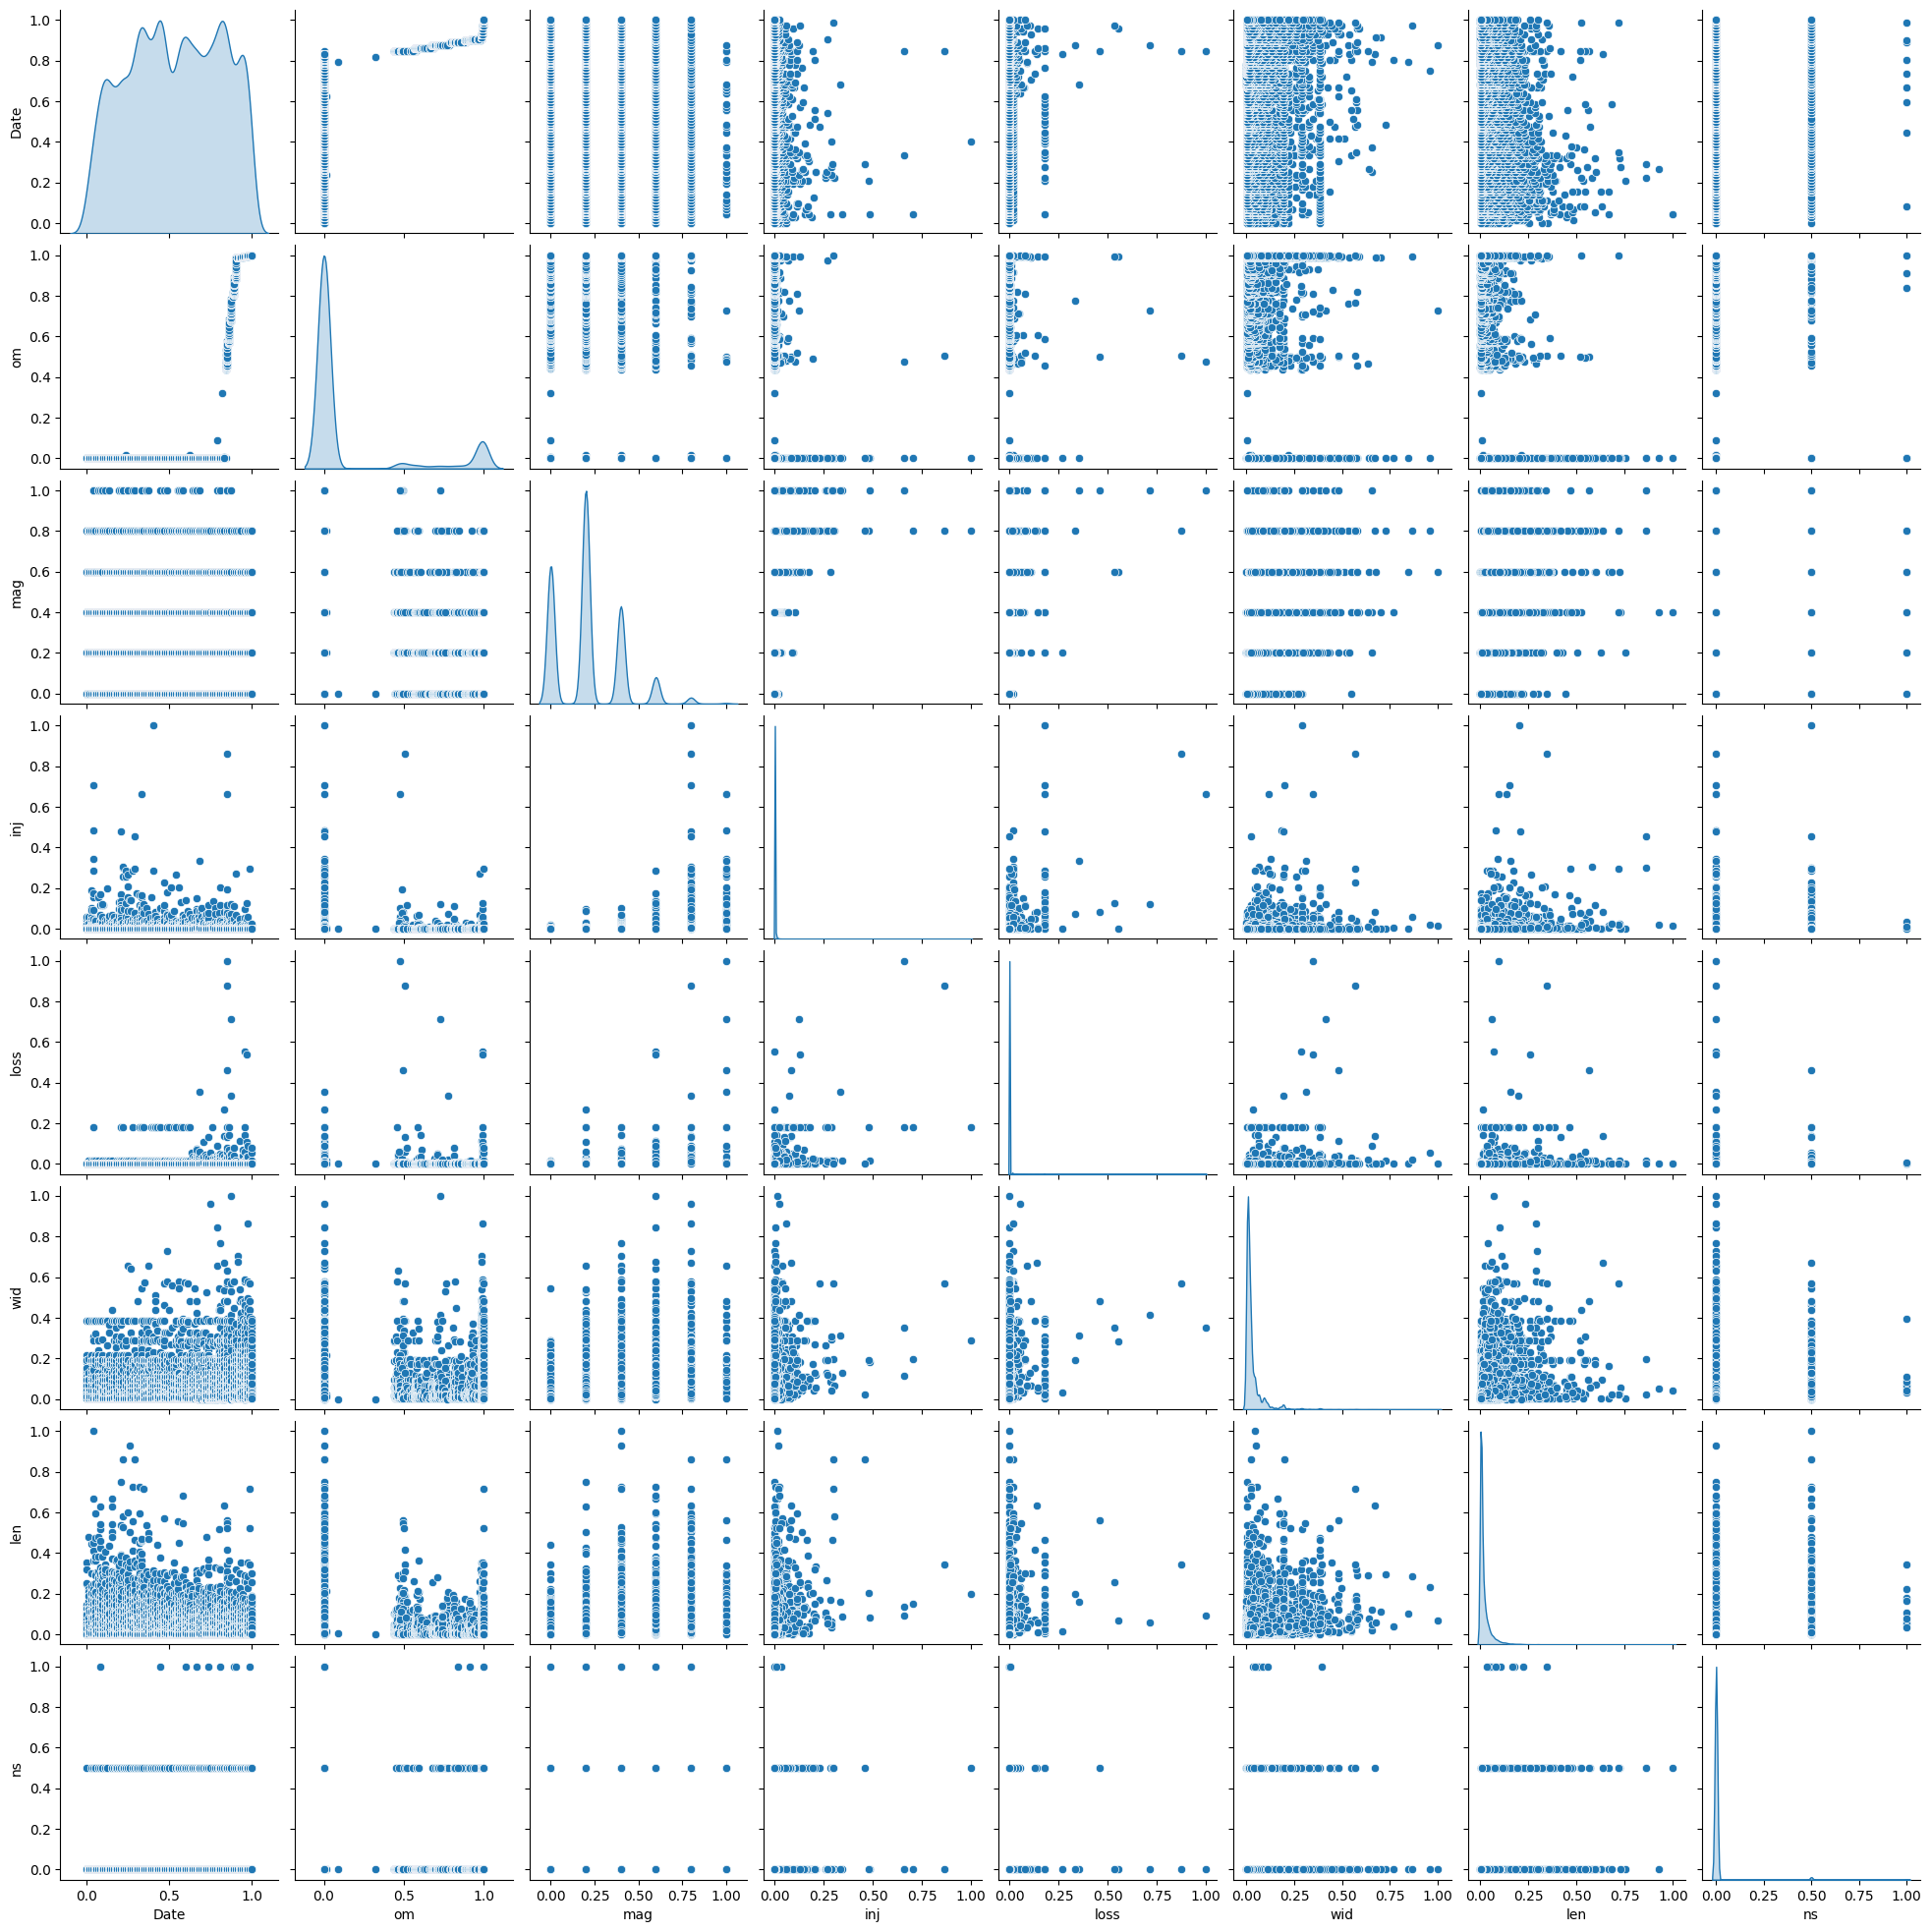

In [10]:
#Scatter plots entre les attributs
attributes=["Date","om","mag","inj","loss","wid","len","ns"]

df_data = pd.DataFrame(data_scaled, columns=attributes)
sns.pairplot(df_data, markers='o', hue=None, diag_kind='kde')
plt.show()


### **Interpretation :**
- Regroupement étroit : Nous remarquons que nos instances sont étroitement groupés, nous ne pouvons separer ces données en clusters pour la plupars des bi-relations des attributs.

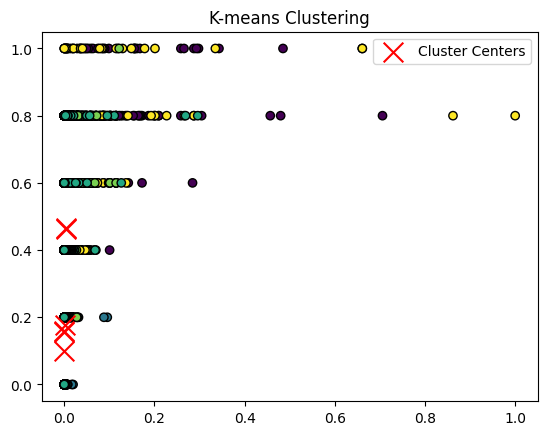

In [11]:
#Utilisation K-means

kmeans = KMeans(n_clusters=6)
kmeans.fit(data_scaled)

centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualizing the clusters
plt.scatter(data_scaled[:, 3], data_scaled[:, 2], c=labels, cmap='viridis', edgecolor='k')
plt.scatter(centers[:, 3], centers[:, 2], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-means Clustering')
plt.legend()
plt.show()

In [12]:
#Metriques pour notre modèle de K-means

# Within-cluster sum of squares
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Silhouette Score :  Measures how similar an object is to its own cluster compared to other clusters
silhouette = silhouette_score(data_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")

Inertia: 1363.9710947141905
Silhouette Score: 0.41209694761668386


### **Interpretation :**

- Nous avons utiliser le modèle K-means avec le nombre de centroides à 6 (nombres de valeurs possible pour magnitude). Nous notons depuis la visualisation de la relation entre l'attribut "mag" et "inj" que les positions des centroides ne divisent pas nos données de façon à ce qu'on detecte les clusters.
- Cela est dù au déséquilibre des nombres d'instances dans nos classes de magnitude.
- Le score de silhouette est de 0.39, qui veut dire qu'il y'a une similation faible des données avec leur propres clusters.
- Nous appliquerons l'algorithme de PCA, qui nous permettera d'avoir de meilleur clusters, et ça nous réduira aussi la dimentionnalité de notre dataset

In [13]:
pc = PCA()
new = pc.fit(data_scaled)

In [14]:
new.explained_variance_ratio_

array([6.86797317e-01, 1.69510488e-01, 1.14093350e-01, 1.44435134e-02,
       8.95311366e-03, 5.03821602e-03, 8.84905748e-04, 2.79094836e-04])

- Dans PCA, nous avons choisi le nombre de composantes principales à 2, car ça permet d'expliquer nos données le mieux possible. (Variance composante 1 : 0.69, Variance composante 2 : 0.17)

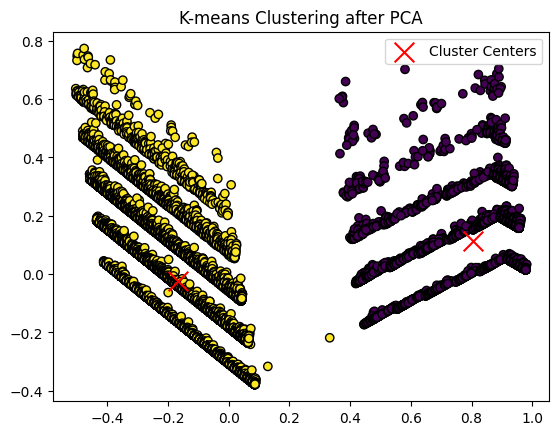

In [15]:
#Application PCA

pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_scaled)

# Apply K-means clustering on the reduced data
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data_reduced)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-means Clustering after PCA')
plt.legend()
plt.show()

### **Interpretation :**
- Après l'application de l'algorithme PCA, nous constatons que les données se sont bien séparé en clusters, dans notre cas 2.
- Les 2 centroides sont bien placé au milieu de leur cluster respectifs.
- La distance entre les centroides est grande, qui implique qu'il y'a une bonne séparation.

In [16]:
#Metriques pour notre modèle de K-means

# Within-cluster sum of squares
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Silhouette Score :  Measures how similar an object is to its own cluster compared to other clusters
silhouette = silhouette_score(data_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")

Inertia: 2465.7421652664425
Silhouette Score: 0.6351787998551441


- Nous remarquons que le score du Silhouette a presque doublé comparé au score avant l'utilisation du PCA.
- L'inertia a augmenté comparé à notre modèle avant l'utilisation du PCA, qui veut dire que nos clusters sont moins compacte.

In [17]:
original_attribute_weights = pd.DataFrame(pca.components_, columns=attributes, index=['PC1', 'PC2'])

# Visualize attribute contributions to the principal components
print("Attribute contributions to PC1 and PC2:")
print(original_attribute_weights)

# Interpret cluster centroids in reduced space
print("Centroids in the reduced space:")
print(centroids)


Attribute contributions to PC1 and PC2:
         Date        om       mag       inj      loss       wid       len  \
PC1  0.596447  0.794271 -0.113708 -0.001281  0.000231  0.020286 -0.003336   
PC2 -0.502513  0.477349  0.712207  0.011401  0.005508  0.080856  0.069176   

           ns  
PC1  0.005532  
PC2  0.029931  
Centroids in the reduced space:
[[ 0.80379882  0.11201558]
 [-0.1675117  -0.02334405]]


### **Interpretation :**
- Nous constatons que pour PC1, les attributs qui ont le plus de poids sont :
  - Date
  - om

- Les attributs avec les poids les plus significatifs sont :
  - Date
  -om
  - mag

### **Parsing du format des dates**
- Formatter les dates et les mettre en index

In [18]:
#Parsing of datetime index
data = dataset.copy()
index_timer = [dt.datetime.strptime(v, '%Y-%m-%d %H:%M:%S') for v in data[data.columns[0]]]

df = data.copy()
df.index = index_timer
df = df.loc[:, df.columns != df.columns[0]].copy()
df.head(10)

,om,st,mag,inj,loss,wid,len,ns
1950-10-02 03:00:00,192,OK,1.0,0,50000.0,10,15.8,1
1950-10-09 08:15:00,193,NC,3.0,3,500000.0,880,2.0,1
1950-11-20 08:20:00,195,KY,2.0,0,500000.0,10,0.1,1
1950-11-20 10:00:00,196,KY,1.0,0,500000.0,10,0.1,1
1950-11-20 13:30:00,197,MS,1.0,3,50000.0,37,2.0,1
1950-11-04 23:00:00,194,PA,3.0,1,500000.0,100,15.9,1
1950-12-02 21:00:00,198,IL,2.0,3,50000.0,50,18.8,1
1950-12-02 22:00:00,199,IL,3.0,25,5000000.0,200,18.0,1
1950-12-02 22:25:00,200,AR,3.0,0,50.0,10,7.8,1
1950-12-02 23:30:00,201,IL,1.0,0,50000.0,50,9.6,1


### **Changement de fréquence des données**


> - La série brute présente une fréquence d'une mesure / heure, nous cherchons à réduire la complexité des données en aggrégeant par rapport au temps la série et ceci en changeant sa fréquence exemple 1 mesure / mois ou 1 mesure / année





In [19]:
#Resampling the time series on different temporal levels to reduce complexity
serie = df['mag']
serie_daily = serie.resample("D").mean()
serie_monthly = serie.resample("M").mean()
serie_yearly = serie.resample("Y").mean()

all_series = [serie, serie_daily, serie_monthly, serie_yearly]

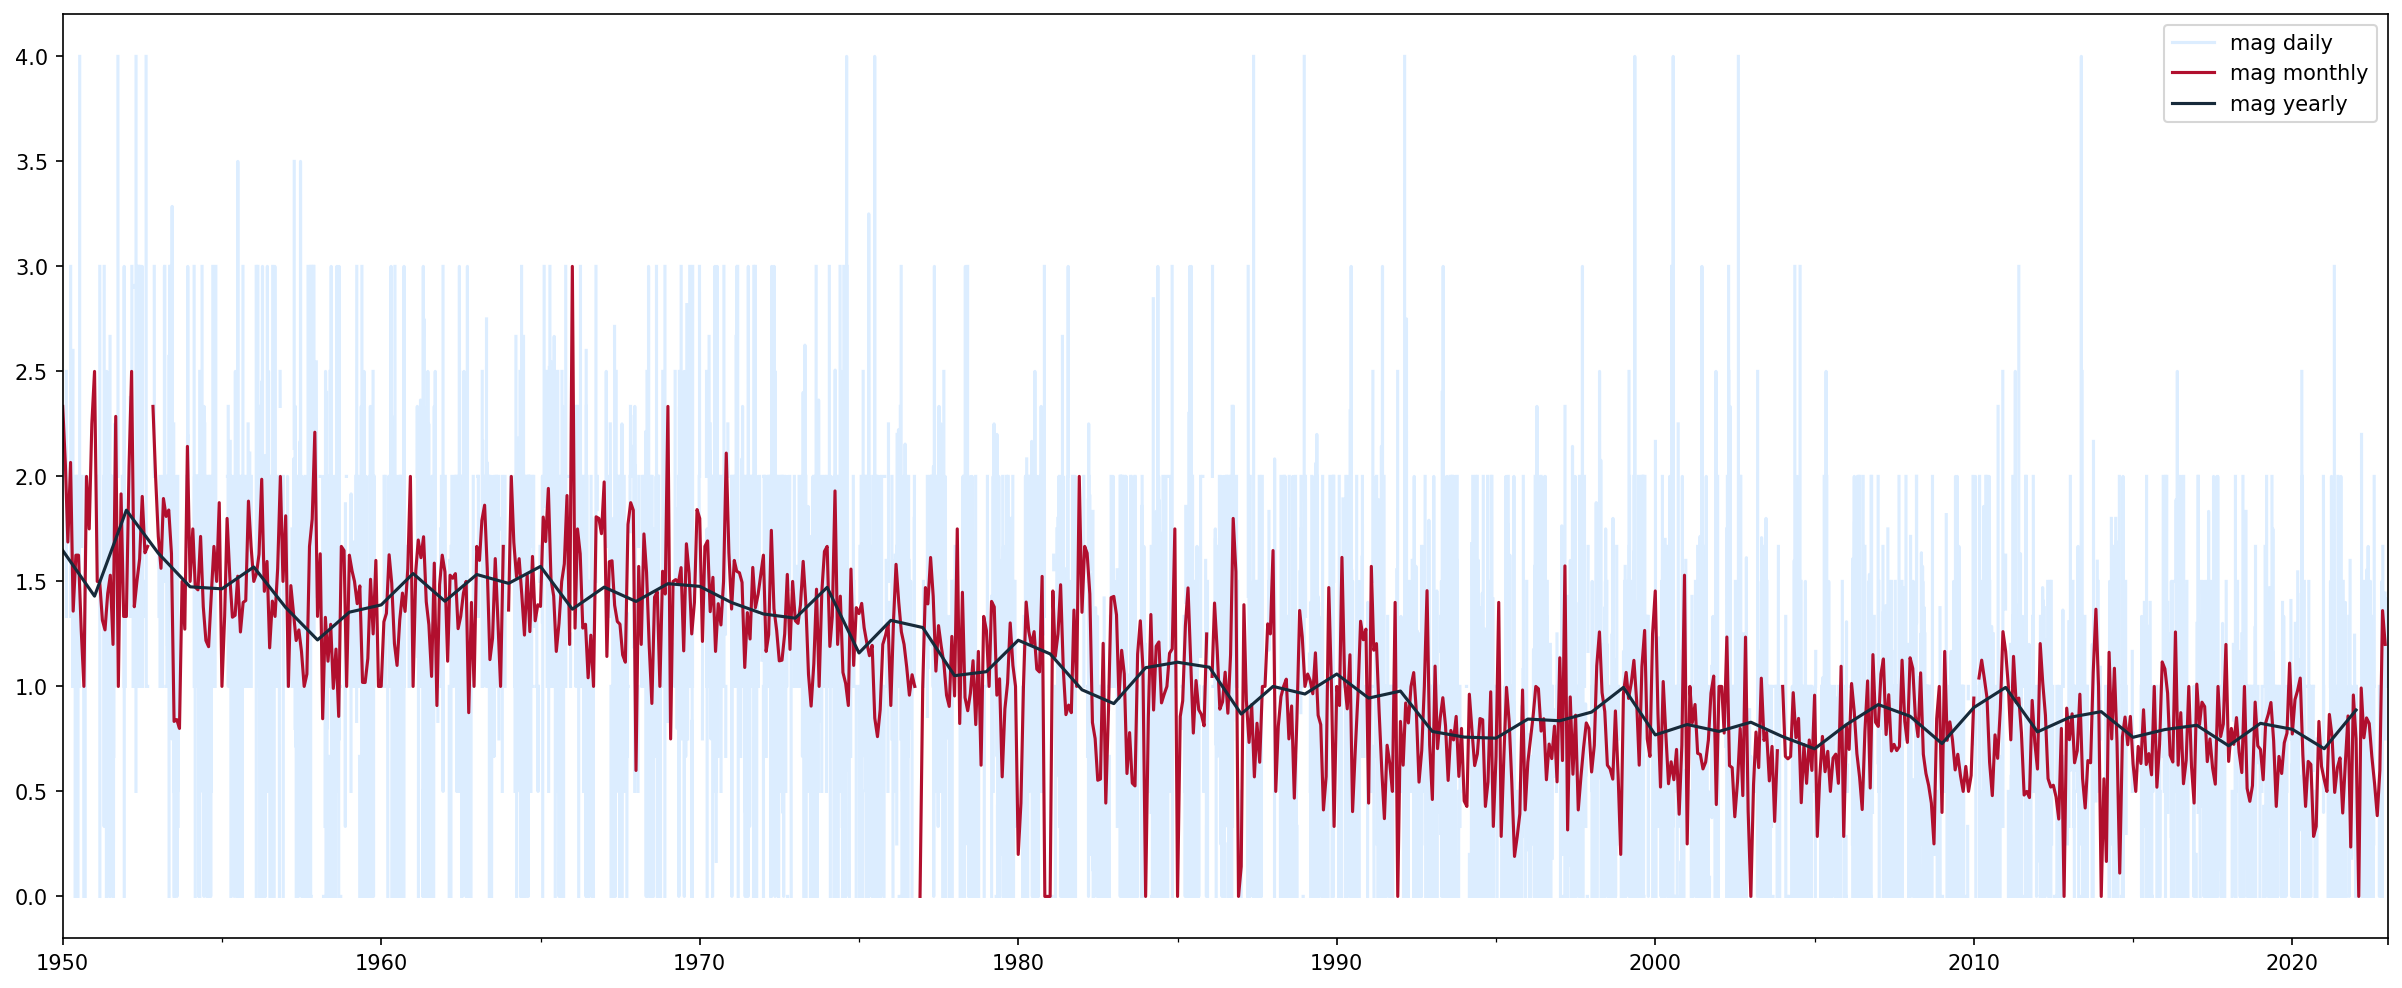

In [20]:
#Visualize the raw plots
plt.figure(figsize=(20, 8), dpi=150)
serie_daily.plot(color='#DCEDFF', label="mag daily")
serie_monthly.plot(color='#B10F2E', label="mag monthly")
serie_yearly.plot(color='#172A3A', label="mag yearly")
plt.legend()
plt.show()

### **Interprétations :**


> - Le graphique montre une tendance claire à l'augmentation de la magnitude des tornades aux États-Unis. Cette tendance pourrait être due au changement climatique ou à l'amélioration des méthodes de détection et de classification des tornades.
- La fréquence annuelle réduit la complexité des données mais en compromis nou perdons les patterns liés à la saisonnalité.
- La fréquence mensuelle permet de réduire la complexité tout en préservant la saisonnalité, la tendance globale et les fluctuations locales de la série.

### **Conclusion :**
Nous continuons notre étude sur la série à fréquence mensuelle.



In [21]:
#Eliminate null values to apply decomposition
serie_monthly = serie_monthly.dropna()

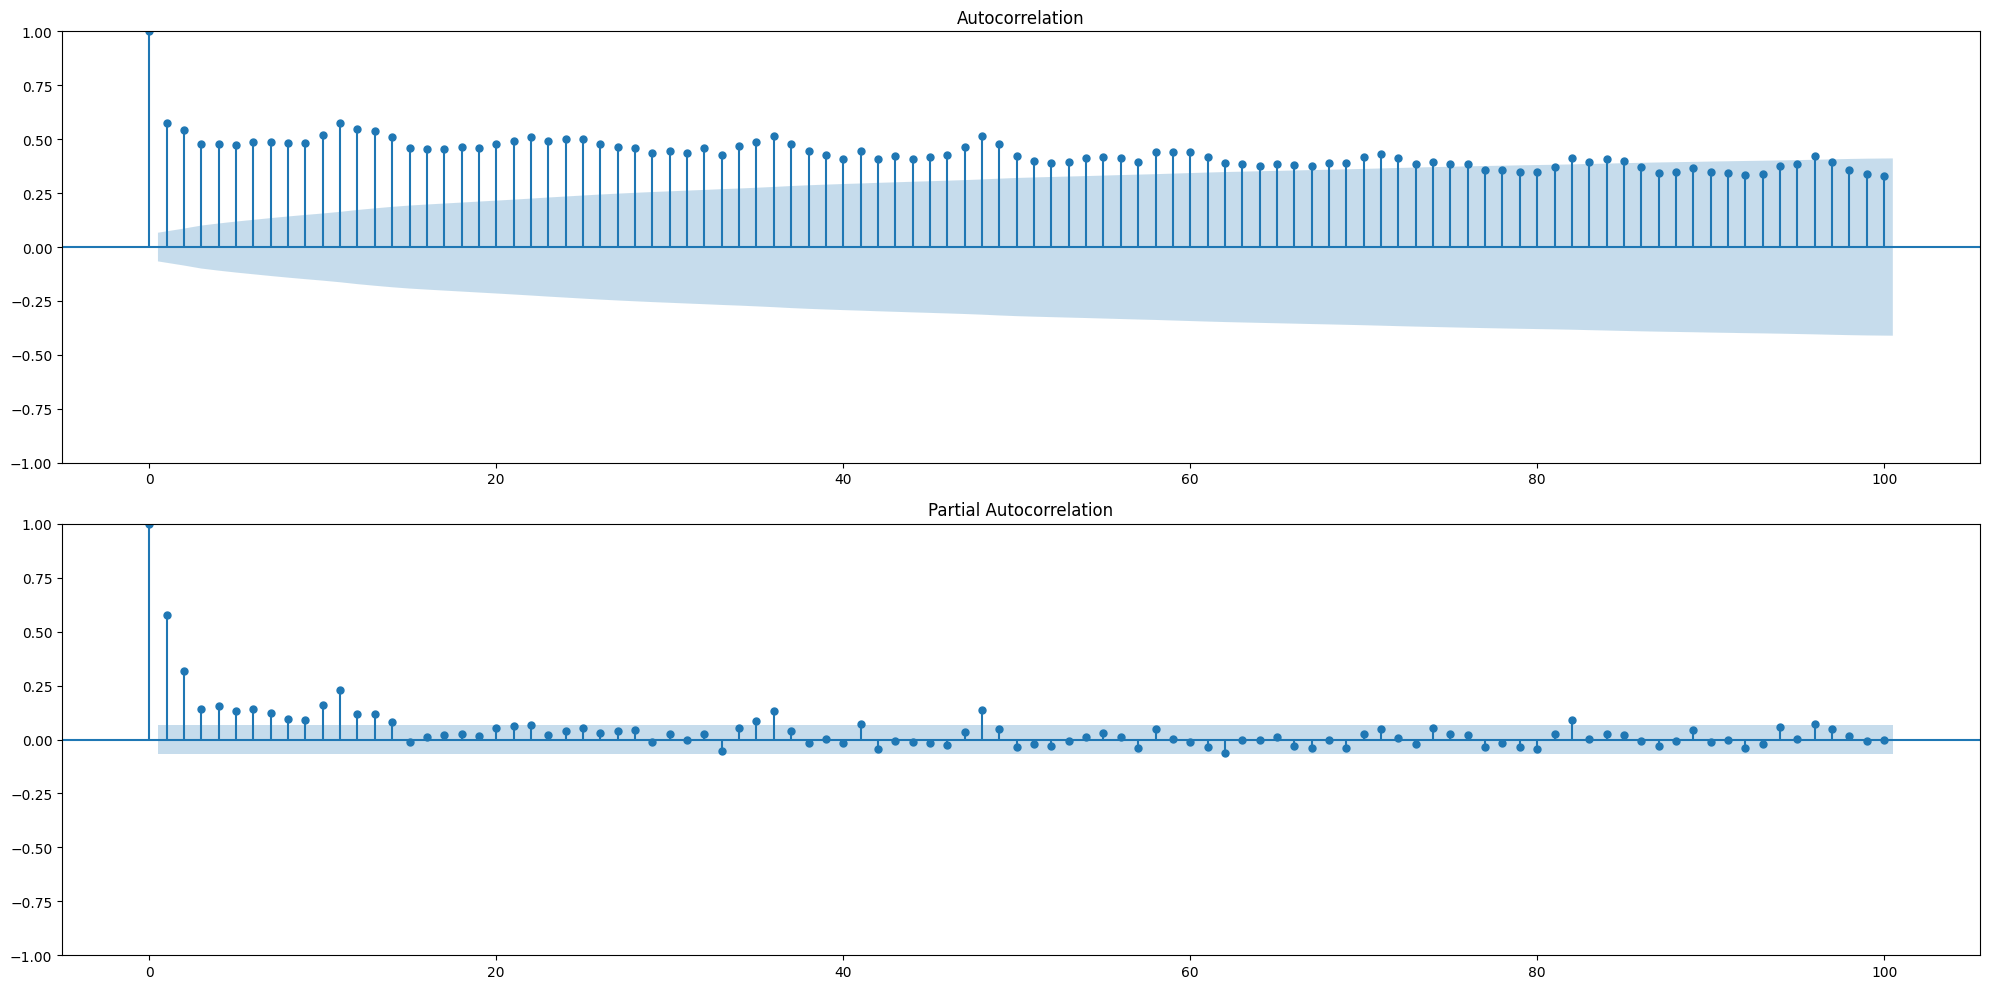

In [22]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(serie_monthly,lags=100, ax=ax[0])
plot_pacf(serie_monthly,lags=100, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [23]:
def multiplicative_decomposition(df: pd.DataFrame, period: int):

    series = df.values
    result = seasonal_decompose(series, model='Multiplicative', period=period)

    return result

result_decomp = multiplicative_decomposition(serie_monthly, period=25)

<Figure size 2000x800 with 0 Axes>

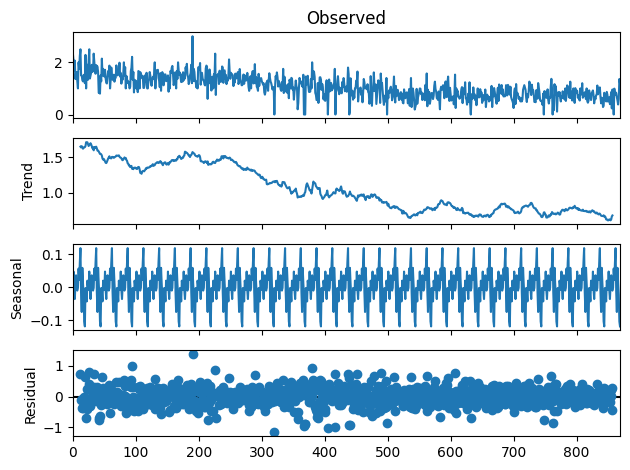

In [24]:
#Visualizing the decomposition
plt.figure(figsize=(20, 8), dpi=100)
result_decomp.plot()
plt.show()

### **Détection des valeurs aberrantes**

In [25]:
def iqr_outliers(data: pd.DataFrame):
    q1,q3 = np.percentile(data,[25,75])
    IQR = q3-q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.values > upper_fence) | (data.values <lower_fence)]


def plot_outliers(outliers: pd.DataFrame, data: pd.DataFrame, method='KNN',
  halignment = 'right',
  valignment = 'bottom',
  labels=False):

  ax = data.plot(alpha=0.8)
  if labels:
    for i in outliers['value'].items():
      plt.plot(i[0],i[1],'rx')
      plt.text(i[0],i[1],f'{i[0].date()}',
      horizontalalignment = halignment,
      verticalalignment = halignment)
  else:
    data.loc[outliers.index].plot(ax=ax,style='rx')


  return plt


In [26]:
result_outliers = iqr_outliers(serie_monthly)

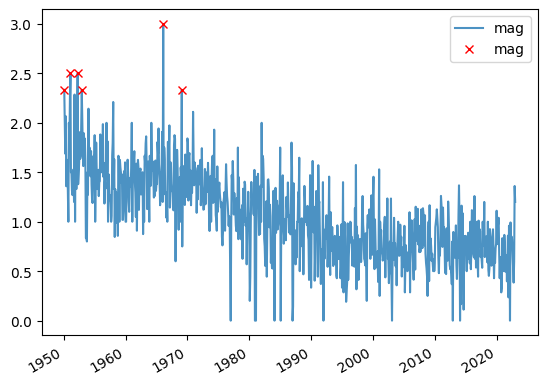

In [27]:
plot_outlier = plot_outliers(result_outliers,serie_monthly,"Outliers using IQR with Tukey's Fences")
plot_outlier.legend()

### **Implémentation de la class de test de stationnarité et transformation de séries non-stationnaires**

In [28]:
class AutoStationary:
    """Transform and inverse_transform a time-series to a stationary version and back.
    Uses boxcox transform and differencing.  Sensible parameters are automatically determined and applied
    with respect to the provided input parameters.
    The inverse_transform() is especially practical for cases in which you have a forecasting model which
    takes transformed data as input.  The output of the model in this case will also be in a transformed
    state, so you need to first inverse_transform() it before you can make sense of your forecast.
    """

    def __init__(self, arr, enabled=True, verbose=True, critical_value='5%'):
        """
        :param arr:             1-dimensional numpy array or pandas Series
        :param enabled:         bool.  If False, temporarily disables all data manipulation.  This can be
                                useful when you want to check the behavior of your code on the original,
                                unmodified data.
        :param verbose:         bool.
        :param critical_value:  str.  Required confidence for the ADF and KPSS stationarity tests.
                                Allowed values: ['1%', 5%', '10%'].  Default: '5%'
        """

        if critical_value not in ['1%', '5%', '10%']:
            raise ValueError(f"critical value must be in ['1%', '5%', '10%']")

        if enabled:
            if not isinstance(arr, pd.Series):
                # create series with a dummy datetimeindex
                arr = pd.Series(arr, index=pd.date_range(start=0, freq='1d', periods=len(arr)))
                self._input_was_array = True
            else:
                self._input_was_array = False

        self._enabled = enabled
        self._arr = arr
        self._arr_index = arr.index
        self._tarr = None
        self._diff_order = None
        self._boxcox_lambda = None
        self._boxcox_shift = 0
        self._transformed = False
        self.stationary = None
        self.critical_value = critical_value
        self.warnings_enabled = verbose

    def is_stationary_ADF(self, arr, return_result=False):
        """Returns whether the array is stationary according to the ADF test.
        ADF = Augmented Dickey Fuller Test.
        :param arr:             1-dimensional numpy array or pandas Series
        :param return_result:   bool: if False, returns a bool.  if True, returns a (bool, dict) tuple.
        :return:                bool or tuple, depending on the `return_result` parameter.
        """
        result = adfuller(arr, autolag='AIC')
        teststat = result[0]
        criticv = result[4][self.critical_value]
        if teststat < criticv:
            if not return_result:
                return True
            else:
                return True, result
        else:
            if not return_result:
                return False
            else:
                return False, result

    def is_stationary_KPSS(self, arr, return_result=False):
        """Returns whether the array is stationary according to the KPSS test.
        KPSS = Kwiatkowski–Phillips–Schmidt–Shin Test.
        :param arr:             1-dimensional numpy array or pandas Series
        :param return_result:   bool: if False, returns a bool.  if True, returns a (bool, dict) tuple.
        :return:                bool or tuple, depending on the `return_result` parameter.
        """
        result = kpss(arr, regression='c')
        teststat = result[0]
        criticv = result[3][self.critical_value]
        if teststat < criticv:
            if not return_result:
                return True
            else:
                return True, result
        else:
            if not return_result:
                return False
            else:
                return False, result

    def is_stationary(self, arr):
        """Returns whether the array is stationary according to both ADF and KPSS.
        :param arr:             1-dimensional numpy array or pandas Series
        :return:                bool
        """

        res_adf = self.is_stationary_ADF(arr)
        res_kpss = self.is_stationary_KPSS(arr)
        if res_adf and res_kpss:
            self.stationary = True
            return True
        else:
            self.stationary = False
            return False

    def transform(self, boxcox_transform=True, diff_orders='auto', enforce_stationarity=True):
        """Returns a stationary version of the array.
        Used techniques are Boxcox transform and differencing of the n-th order.
        Both ADF and KPSS stationary tests have to pass before we consider the array stationary.
        :param boxcox_transform:        Deal with unstable variance by transforming the array before
                                        applying differencing.  True, False, or float.
                                            Set to False to disable boxcox transformation.
                                            Set to 0.0 to do a log transform.
                                            Set to True to automatically determine the optimal (float) value.
        :param diff_orders:             Determines the maximum order of differencing.
                                            int:                difference the series by the specified order
                                            list of ints:       try all orders specified in the list
                                            'auto' (default):   uses np.arange(1, 25)
        :param enforce_stationarity:    If True, raise an Exception if we fail to make array stationary.
                                        If False, instead of an Exception, the array will return with
                                        diff_orders[0] differencing.
                                        Note: if False, and verbose is also False, you may be returned
                                        a non-stationary array as output without being aware of it!
        :return:                        Stationary version of the array (For edge cases read above).
        """

        # input validation
        if diff_orders == 'auto':
            orders = np.arange(1, 25)
        elif isinstance(diff_orders, int):
            orders = [diff_orders]
        elif isinstance(diff_orders, list):
            if not (isinstance(diff_orders[0], int)):
                raise ValueError('diff_orders must be integers.')
        if self._transformed:
            raise ValueError('array already transformed!', UserWarning)

        # do nothing
        if not self._enabled:
            return self._arr

        # if already stationary, do nothing
        if self.is_stationary(self._arr):
            if self.warnings_enabled:
                warnings.warn('array already stationary.  Returning original array.', UserWarning)
            self._transformed = False
            return self._arr

        # boxcox transformation
        tarr = self._arr
        if boxcox_transform:
            # boxcox requires a strictly positive array
            lowest = np.min(tarr)
            if lowest <= 0:
                self._boxcox_shift = np.abs(lowest) + 1
                tarr = tarr + self._boxcox_shift

            if isinstance(boxcox_transform, float):
                # lambda was specified
                self._boxcox_lambda = boxcox_transform
                tarr = boxcox(tarr, boxcox_transform)
            else:
                # find best lambda
                tarr, lmbda = boxcox(tarr)
                self._boxcox_lambda = lmbda
            tarr = pd.Series(tarr, index=self._arr_index)  # store transformed arr
            self._tarr = tarr

        # find best order
        for o in orders:
            arrdiff = np.roll(tarr, o)
            arrdiff = tarr - arrdiff
            arrdiff = arrdiff[o:]
            if self.is_stationary(arrdiff):
                self._diff_order = o
                self._transformed = True
                if self._input_was_array:
                    return arrdiff.values
                else:
                    return arrdiff

        # failed to make it stationary
        self.stationary = False
        if enforce_stationarity:
            raise ValueError('Could not make the arr stationary with given parameters.')
        else:
            if self.warnings_enabled:
                warnings.warn(f'Could not make the arr stationary with given parameters.  Returning difference with order {orders[0]}.', UserWarning)
            self._diff_order = orders[0]
            arrdiff = np.roll(tarr, self._diff_order)
            arrdiff = tarr - arrdiff
            arrdiff = arrdiff[self._diff_order:]
            self._transformed = True
            if self._input_was_array:
                return arrdiff.values
            else:
                return arrdiff

    def inverse_transform(self, diffarr):
        if not self._enabled:
            return diffarr

        if isinstance(diffarr, pd.Series):
            diffarr = diffarr.values

        if not self._transformed:
            if self.warnings_enabled:
                warnings.warn('The original array was never transformed.  Returning the same array you just passed.', UserWarning)
            return diffarr

        # insert the start of the original series
        if self._tarr is None:
            diffarr = np.insert(diffarr, [0], self._arr[:self._diff_order])
        else:
            # a boxcox was applied
            diffarr = np.insert(diffarr, [0], self._tarr[:self._diff_order])

        # append 0's as padding if required
        if (len(diffarr) % self._diff_order) == 0:
            padlen = 0
        else:
            padlen = self._diff_order - (len(diffarr) % self._diff_order)
        diffarr = np.append(diffarr, np.zeros(padlen))

        # cumsum while accounting for order
        nrows = len(diffarr) // self._diff_order
        diffarr = np.reshape(diffarr, (nrows, self._diff_order))
        inv = np.cumsum(diffarr, axis=0)

        # cleanup
        inv = inv.flatten()
        if padlen > 0:
            inv = inv[:-padlen]

        # inverse boxcox
        if self._boxcox_lambda is not None:
            inv = inv_boxcox(inv, self._boxcox_lambda)

        # inverse boxcox shift
        if self._boxcox_shift != 0:
            inv = inv - self._boxcox_shift

        # add index if it was a series originally
        if not self._input_was_array:
            # we must auto-extend the index if the arr is now longer.
            idxorig = self._arr_index
            idxtoadd = [idxorig.index[-1] + i + 1 for i in range(len(inv) - len(idxorig))]
            idxnew = idxorig.union(idxtoadd)
            # but we must also handle a potentially shorter array
            idxnew = idxnew[:len(inv)]
            inv = pd.Series(inv, index=idxnew)
        return inv

    def summary(self):
        """returns a summary of the current state of the array"""

        if not self._enabled:
            return {'warning': 'arr was not transformed in any way cause user set enabled.'}
        else:
            _, adf_result = self.is_stationary_ADF(self._arr, return_result=True)
            _, kpss_result = self.is_stationary_KPSS(self._arr, return_result=True)

            return ({'transformed': self._transformed,
                    'stationary': self.stationary,
                    'diff_order': self._diff_order,
                    'boxcox_lambda': self._boxcox_lambda,
                    'boxcox_shift': self._boxcox_shift,
                    'adf_result': pd.Series(adf_result[:5], index=['test_statistic', 'p', 'n_lags', 'n_obs', 'critical_value']).to_dict(),
                    'kpss_result': pd.Series(kpss_result[:4], index=['test statistic', 'p', 'n_lags', 'critical_value']).to_dict()
                    })

In [29]:
stationarity_test = AutoStationary(serie_monthly)
stationarity_test.is_stationary(serie_monthly)
stationary_serie_monthly = stationarity_test.transform()
stationarity_test.summary()

<ipython-input-28-8d8610b904c9>:72: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(arr, regression='c')
<ipython-input-28-8d8610b904c9>:72: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(arr, regression='c')
<ipython-input-28-8d8610b904c9>:72: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(arr, regression='c')


{'transformed': True,
 'stationary': True,
 'diff_order': 1,
 'boxcox_lambda': 0.5263982799710653,
 'boxcox_shift': 1.0,
 'adf_result': {'test_statistic': -2.217699944585761,
  'p': 0.19988422875619571,
  'n_lags': 13,
  'n_obs': 856,
  'critical_value': {'1%': -3.4380124044615803,
   '5%': -2.8649223608717205,
   '10%': -2.5685710298388504}},
 'kpss_result': {'test statistic': 4.436628523236452,
  'p': 0.01,
  'n_lags': 17,
  'critical_value': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}}

### **Interprétation des résultats**


> - La série originale n'était pas stationnaire
- Une différenciation d'ordre = 1 est requise
- La p-value du test KPSS a renvoyé une valeur < 5% après différenciation, donc l'hypothèse nulle H0: "La série est stationnaire" est retenue.




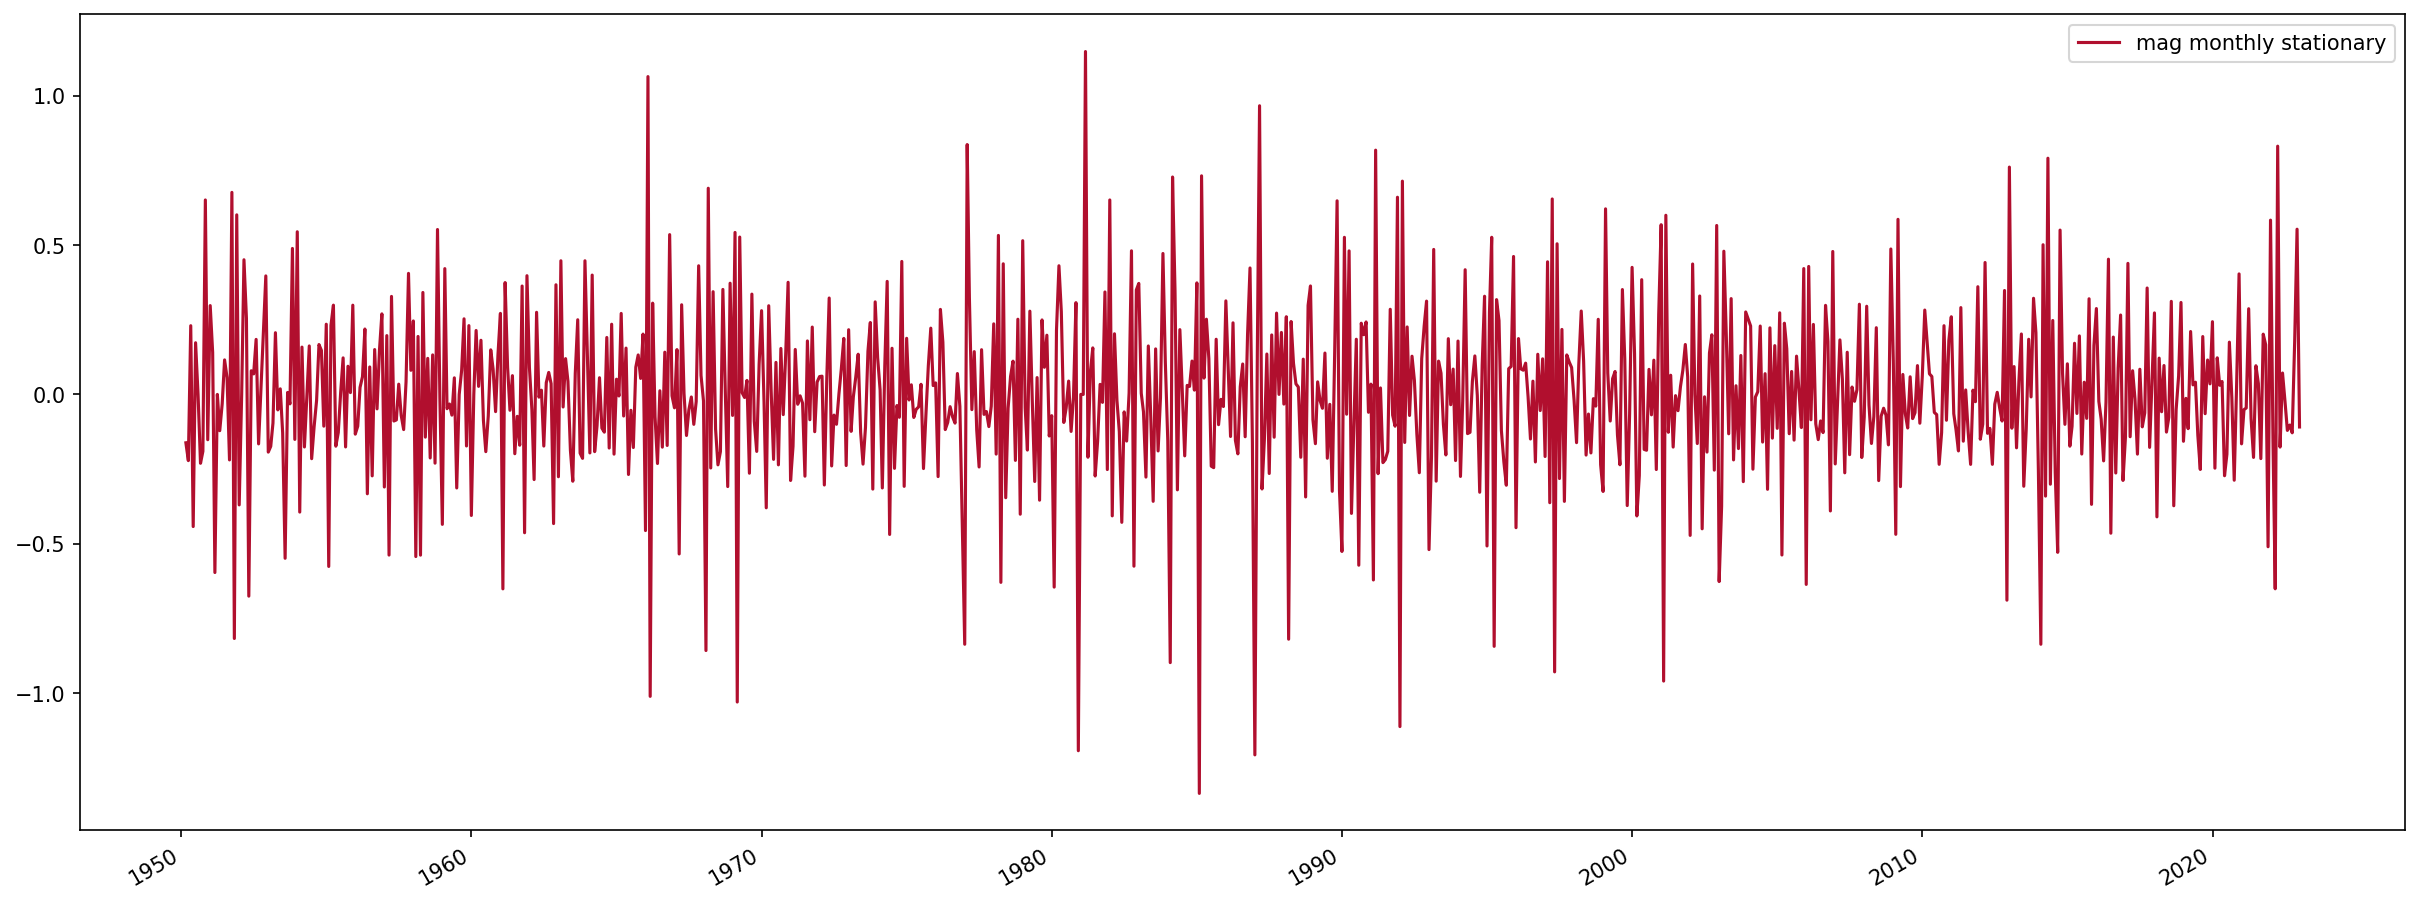

In [30]:
#Plot the transformed stationary time serie
plt.figure(figsize=(20, 8), dpi=150)
stationary_serie_monthly.plot(color='#B10F2E', label="mag monthly stationary")
plt.legend()
plt.show()

### **Explication du graphe:**
- La série stationnaire exhibe une moyenne qui fluctue autour de 0 et ne présentant pas de saisonnalité, donc stationnaire

### **Implémentation des modèles supervisés de prédiction de séries temporelles**
Nous comparons dans ce qui suit la performance des modèles qui permettent de prédire le comportement future d'une série temporelle. Nous avons choisi le modèle statistique de référence ARIMA et appliqué la régression linéaire, XGBoost et les forets aléatoires (pour une tache de régression)

In [31]:
# Implementing prediction models for time series
class TimeSeriesForecasting:
    def __init__(self, data):
        self.data = data
        self.train_size = int(len(data) * 0.8)
        self.train_data = data[:self.train_size]
        self.test_data = data[self.train_size:]

    def fit_arima(self, order=(5, 1, 0)):

          history = [x for x in self.train_data]
          y = self.test_data
          history = [x for x in self.train_data]
          y = self.test_data
          # make first prediction
          predictions = list()
          model = ARIMA(history, order=order)
          model_fit = model.fit()
          yhat = model_fit.forecast()[0]
          predictions.append(yhat)
          history.append(y[0])

          for i in range(1, len(y)):
              # predict
              model = ARIMA(history, order=order)
              model_fit = model.fit()
              yhat = model_fit.forecast()[0]
              # invert transformed prediction
              predictions.append(yhat)
              # observation
              obs = y[i]
              history.append(obs)

          self.arima_model = model_fit

          return predictions

    def fit_random_forest(self):
        model = RandomForestRegressor()
        X_train, y_train = self.prepare_features(self.train_data)
        model.fit(X_train, y_train)
        self.rf_model = model

    def fit_linear_regression(self):
        model = LinearRegression()
        X_train, y_train = self.prepare_features(self.train_data)
        model.fit(X_train, y_train)
        self.lr_model = model

    def predict_linear_regression(self):
        X_test, _ = self.prepare_features(self.test_data)
        lr_pred = self.lr_model.predict(X_test)
        return lr_pred



    def fit_xgboost(self):
        model = XGBRegressor()
        X_train, y_train = self.prepare_features(self.train_data)
        model.fit(X_train, y_train)
        self.xgb_model = model

    def prepare_features(self, data):
        X = pd.DataFrame({"lag1": data.shift(1), "lag2": data.shift(2)})
        X = X.dropna()
        y = data[2:]
        return X, y

    def predict(self):
          arima_pred = self.fit_arima(order=(1,1,0))
          self.fit_random_forest()
          self.fit_linear_regression()
          self.fit_xgboost()

          predictions = pd.DataFrame(index=self.test_data.index[:-2])

          # ARIMA prediction

          predictions["ARIMA"] = arima_pred[:-2]

          # Random Forest prediction
          X_test_rf, _ = self.prepare_features(self.test_data)
          rf_pred = self.rf_model.predict(X_test_rf)
          predictions['RandomForest'] = rf_pred

          # Linear Regression prediction
          lr_pred = self.predict_linear_regression()
          predictions['LinearRegression'] = lr_pred


          # XGBoost prediction
          X_test_xgb, _ = self.prepare_features(self.test_data)
          xgb_pred = self.xgb_model.predict(X_test_xgb)
          predictions['XGBoost'] = xgb_pred



          return predictions




    def plot_forecasts(self, predictions):
        for model in predictions.columns:
            plt.figure(figsize=(12, 6))

            # Plot the training data in blue
            plt.plot(self.train_data, label="Training Data", color='blue')

            # Plot the test data in green
            plt.plot(self.test_data, label="Test Data", color='green')

            # Plot the forecasted series with a unique color
            if model == 'ARIMA':
                color = 'red'
            elif model == 'RandomForest':
                color = 'purple'
            elif model == 'LinearRegression':
                color = 'orange'
            elif model == 'XGBoost':
                color = 'cyan'
            else:
                color = 'gray'

            plt.plot(predictions[model], label=model, color=color)

            # Customize the legend
            plt.legend(loc="upper left")

            # Set the title
            plt.title("Time Series Forecasting - " + model)

            # Display the plot for the current model
            plt.show()


    def calculate_metrics(self, predictions):
        metrics = pd.DataFrame(columns=["Model", "RMSE", "MSE"])

        for model in predictions.columns:
            # Align test data and predictions
            model_predictions = predictions[model].values[-len(self.test_data):]

            rmse = np.sqrt(mean_squared_error(self.test_data[:-2], model_predictions))
            mse = mean_squared_error(self.test_data[:-2], model_predictions)
            metrics = metrics.append({"Model": model, "RMSE": rmse, "MSE": mse}, ignore_index=True)

        return metrics

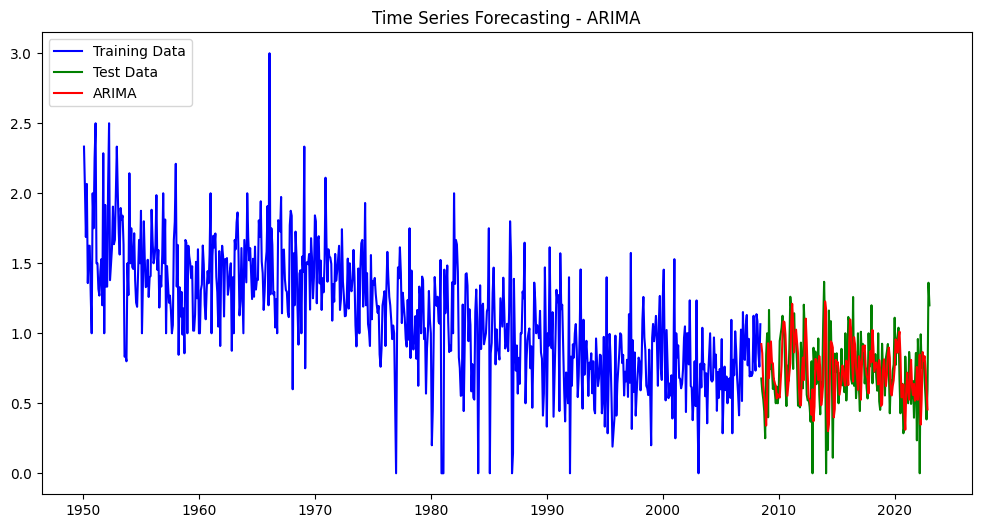

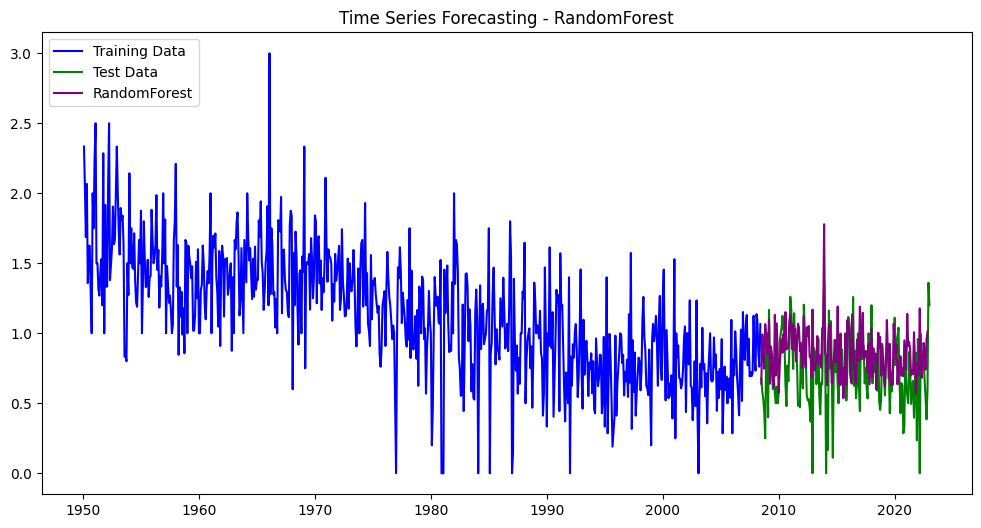

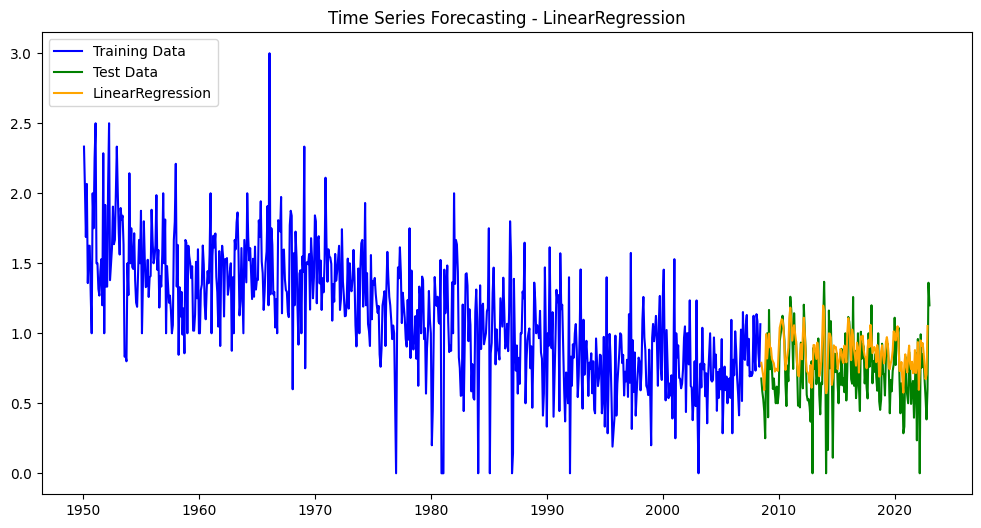

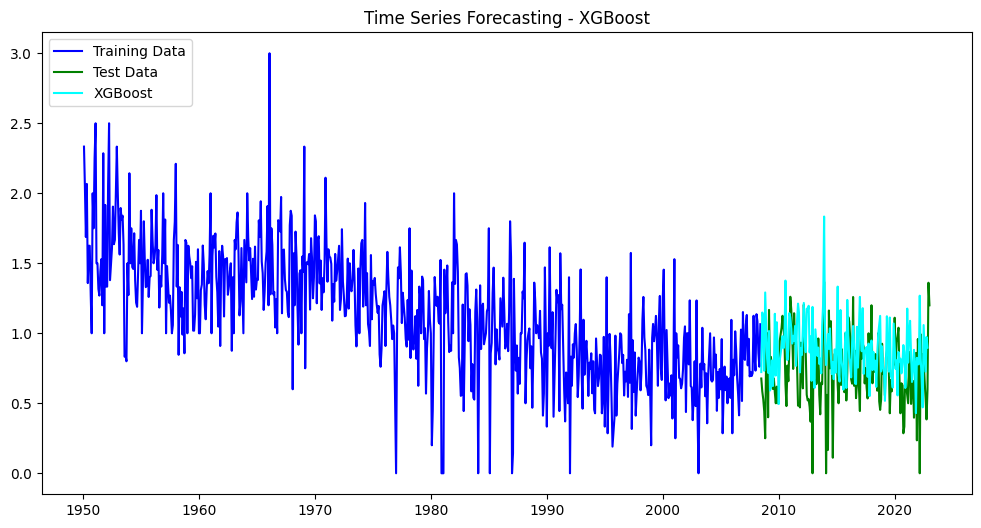

In [32]:
data = serie_monthly
# Initialize the forecasting class
ts_forecast = TimeSeriesForecasting(data)

# Make predictions
predictions = ts_forecast.predict()

# Plot forecasts
ts_forecast.plot_forecasts(predictions)

# Calculate and display metrics
predictions = predictions.fillna(0)
metrics = ts_forecast.calculate_metrics(predictions)

In [33]:
metrics

,Model,RMSE,MSE
0,ARIMA,0.290993,0.084677
1,RandomForest,0.310461,0.096386
2,LinearRegression,0.226749,0.051415
3,XGBoost,0.349817,0.122372


### **Interprétation des résultats**


> -  Le modèle ARIMA



# **Partie 2 : Etude supervisée de la tache de classification**

### **Choix de la cible :**
- Pour creer un modèle de classification, nous avons besoin de choisir la cible parmis les attributs de notre dataset.
- Nous avons choisi de creer un nouveau attribut qui representera la moyenne entre les valeurs normalisées des attributs "inj" et "loss". Qui representent les dommages humaines et materiels.


In [34]:
#Normalisation puis fusion des colonnes "inj" et "loss" pour avoir la moyenne.
data = dataset.copy()
scaler = MinMaxScaler()

Y=data[["inj","loss"]]
Y.head()
Y_scaled=scaler.fit_transform(Y)
average_loss = np.mean(Y_scaled, axis=1)
print(average_loss)

[8.91932447e-06 9.51342564e-04 8.92735990e-05 ... 8.91932447e-06
 3.48201856e-07 2.13385240e-06]


- Après la création de notre nouvel attribut. Nous allons allouer ses valeurs au classes ci-dessous :
  - No impact : pour la valeur 0.
  - Low impact : Pour les valeurs entre 0 et 0.00002.
  - Medium impact : Pour les valeurs entre 0.00002 et 0.001.
  - High impact : Pour les valeurs superieur à 0.001.

In [35]:
#Coder la cible dans les classes suivantes :
#["No Impact" : 0,"Low Impact" : 1, "Medium Impact" : 2, "High Impact" : 3]

df= pd.DataFrame(average_loss)

final_Y=[]

for i in average_loss :
  if i==0 :
    final_Y.append(0)
  elif i<=0.00002 :
    final_Y.append(1)
  elif i<=0.001 :
    final_Y.append(2)
  else :
    final_Y.append(3)

class_counts = Counter(final_Y)

for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} occurrences")

df.describe().T

Class 1: 24209 occurrences
Class 2: 12077 occurrences
Class 3: 3679 occurrences
Class 0: 1552 occurrences


,count,mean,std,min,25%,50%,75%,max
0,41517.0,0.000987,0.010484,0.0,0.000002,0.000009,0.000089,0.868519


- Nous avons utilisé le target encoding sur l'attribut "st" pour les raisons suivantes :
  - Le label encoding n'est pas utilisable car ça donnera des differences illogique et instable entre les états.
  - Le "one-hot-encoding" n'est pas utilisable car nous avons 52 valeurs unique dans l'attribut, ce qui nous obligera a creer 52 attributs, qui causera un probléme de dimensionnalité.
  - Le target encoding encode les valeurs avec la probabilité p(target = class | x = sti), qui veud dire la probabilité postérieure du target est égale par exemple à "Low impact" étant donné que l'entrée (st) était la catégorie sti.

In [36]:
#Encodage de l'attribut "st" avec le "target encoding"
encoder = ce.TargetEncoder(cols=['st'])

# Fit the encoder on the 'state' column and transform it
df_encoded = encoder.fit_transform(data['st'], final_Y)

data['state_encoded'] = df_encoded
data2=data.drop(["st"],axis=1)
print(data2)

                Unnamed: 0      om  mag  inj      loss  wid    len  ns  \
0      1950-10-02 03:00:00     192  1.0    0   50000.0   10  15.80   1   
1      1950-10-09 08:15:00     193  3.0    3  500000.0  880   2.00   1   
2      1950-11-20 08:20:00     195  2.0    0  500000.0   10   0.10   1   
3      1950-11-20 10:00:00     196  1.0    0  500000.0   10   0.10   1   
4      1950-11-20 13:30:00     197  1.0    3   50000.0   37   2.00   1   
...                    ...     ...  ...  ...       ...  ...    ...  ..   
41512  2022-09-28 00:30:00  621917  1.0    0   50000.0  100   1.39   1   
41513  2022-09-28 04:31:00  621919  0.0    0   10000.0   50   0.06   1   
41514  2022-09-28 05:25:00  621920  0.0    0   50000.0   75   1.09   1   
41515  2022-09-28 08:56:00  621921  0.0    0    2000.0   50   0.20   1   
41516  2022-09-04 20:44:00  621900  0.0    0   12000.0   15   0.07   1   

       state_encoded  
0           1.336535  
1           1.534579  
2           1.597345  
3           1.59734

In [37]:
#Encodage de la date a un entier avec l'expression suivante : YYYYMMDDHHmmSS
data2[data2.columns[0]]=data2[data2.columns[0]].str.replace(r'[- :]', '', regex=True)

X=data2.drop(columns=["inj","loss"])
X.head()

,Unnamed: 0,om,mag,wid,len,ns,state_encoded
0,19501002030000,192,1.0,10,15.8,1,1.336535
1,19501009081500,193,3.0,880,2.0,1,1.534579
2,19501120082000,195,2.0,10,0.1,1,1.597345
3,19501120100000,196,1.0,10,0.1,1,1.597345
4,19501120133000,197,1.0,37,2.0,1,1.490720


In [38]:
#Data Split
X1, X2, Y1, Y2 = train_test_split(X, final_Y,test_size=0.5,shuffle="random")

In [39]:
#Utilisation de la normalisation Min-Max sur les X d'entrainement et de test.
scaler = MinMaxScaler()

X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

target_names=["No Impact","Low Impact","Medium Impact", "High Impact"]
print(X1_scaled)

[[6.10737163e-01 6.23714994e-04 0.00000000e+00 ... 4.59136823e-04
  0.00000000e+00 5.07380978e-01]
 [4.44748408e-01 1.39532117e-03 0.00000000e+00 ... 4.59136823e-04
  0.00000000e+00 4.93242220e-01]
 [9.77800524e-02 9.08244773e-04 6.00000000e-01 ... 4.59136823e-04
  0.00000000e+00 7.87507733e-01]
 ...
 [5.00079826e-01 8.88954618e-04 2.00000000e-01 ... 4.59136823e-04
  0.00000000e+00 4.93242220e-01]
 [9.43268076e-01 9.90186134e-01 0.00000000e+00 ... 3.76492195e-03
  0.00000000e+00 7.72197805e-01]
 [6.24726102e-01 1.23939242e-03 0.00000000e+00 ... 4.59136823e-04
  0.00000000e+00 5.31103177e-01]]


In [40]:
# Test de Classification avec KNN + Sauvegarde de resultats pour les differentes valeurs de n dans le fichier "results_knn.json".
global_dict=[]

for n in range(3,51,2) :

  knn_classifier = KNeighborsClassifier(n_neighbors=n)
  knn_classifier.fit(X1_scaled, Y1)

  y_pred = knn_classifier.predict(X2_scaled)

  accuracy = accuracy_score(Y2, y_pred)
  precision = precision_score(Y2, y_pred,average='weighted')
  recall = recall_score(Y2, y_pred,average='weighted')
  fscore= f1_score(Y2,y_pred,average='weighted')

  result={
          "Accuracy":accuracy,
          "precision":precision,
          "recall":recall,
          "f1score":fscore
          }
  dictionnary={"n" : {n : result}}
  global_dict.append(dictionnary)

final_dict={"knn"
            :global_dict}

print(classification_report(Y2, y_pred, target_names=target_names))

with open("/content/results_knn.json", 'w') as json_file:
    json.dump(final_dict, json_file, indent=4)
    json_file.close()

               precision    recall  f1-score   support

    No Impact       0.60      0.38      0.47       785
   Low Impact       0.72      0.89      0.79     12138
Medium Impact       0.53      0.38      0.44      5980
  High Impact       0.68      0.29      0.41      1856

     accuracy                           0.67     20759
    macro avg       0.63      0.49      0.53     20759
 weighted avg       0.65      0.67      0.65     20759



In [41]:
#Test de Classification avec SVM + Sauvegarde de resultats pour les differentes valeurs de c dans le fichier "results_svm.json".
global_dict=[]

for c in range (1,110,10) :

  model_svm = SVC(kernel='linear', C=c)

  model_svm.fit(X1_scaled, Y1)
  y_pred = model_svm.predict(X2_scaled)

  accuracy = accuracy_score(Y2, y_pred)
  precision = precision_score(Y2, y_pred,average='weighted')
  recall = recall_score(Y2, y_pred,average='weighted')
  fscore= f1_score(Y2,y_pred,average='weighted')

  result={"Accuracy":accuracy,"precision":precision,"recall":recall,"f1score":fscore}
  dictionnary={"c" : {c : result}}
  global_dict.append(dictionnary)

final_dict={"svm":global_dict}

print(classification_report(Y2, y_pred, target_names=target_names))

with open("/content/results_svm.json", 'w') as json_file:
    json.dump(final_dict, json_file,indent=4)
    json_file.close()


               precision    recall  f1-score   support

    No Impact       0.00      0.00      0.00       785
   Low Impact       0.69      0.93      0.79     12138
Medium Impact       0.52      0.33      0.40      5980
  High Impact       0.75      0.23      0.36      1856

     accuracy                           0.66     20759
    macro avg       0.49      0.37      0.39     20759
 weighted avg       0.62      0.66      0.61     20759



In [42]:
#Test de classification avec Naive Bayes
model_NB = MultinomialNB()
model_NB.fit(X1_scaled, Y1)

y_pred = model_NB.predict(X2_scaled)

# Evaluate the performance
print(classification_report(Y2, y_pred, target_names=target_names))

accuracy_nb = accuracy_score(Y2, y_pred)
precision_nb = precision_score(Y2, y_pred,average='weighted')
recall_nb = recall_score(Y2, y_pred,average='weighted')
fscore_nb= f1_score(Y2,y_pred,average='weighted')

               precision    recall  f1-score   support

    No Impact       0.00      0.00      0.00       785
   Low Impact       0.59      1.00      0.74     12138
Medium Impact       0.26      0.01      0.01      5980
  High Impact       0.88      0.01      0.01      1856

     accuracy                           0.59     20759
    macro avg       0.43      0.25      0.19     20759
 weighted avg       0.50      0.59      0.44     20759



In [43]:
#Test de Classification avec Random Forest + Sauvegarde de resultats pour les differentes valeurs de N dans le fichier "results_rf.json".
global_dict=[]

for n in range (10,150,10):
  model = RandomForestClassifier(n_estimators=n, max_depth=None)

  model.fit(X1_scaled, Y1)
  y_pred = model.predict(X2_scaled)

  accuracy = accuracy_score(Y2, y_pred)
  precision = precision_score(Y2, y_pred,average='weighted')
  recall = recall_score(Y2,y_pred,average='weighted')
  fscore= f1_score(Y2,y_pred,average='weighted')

  result={"Accuracy":accuracy,"precision":precision,"recall":recall,"f1score":fscore}
  dictionnary={"n" : {n : result}}
  global_dict.append(dictionnary)

final_dict={"random forest":global_dict}

print(classification_report(Y2, y_pred, target_names=target_names))

with open("/content/results_rf.json", 'w') as json_file:
    json.dump(final_dict, json_file,indent=4)
    json_file.close()


               precision    recall  f1-score   support

    No Impact       0.80      0.42      0.55       785
   Low Impact       0.74      0.87      0.80     12138
Medium Impact       0.52      0.43      0.47      5980
  High Impact       0.60      0.37      0.46      1856

     accuracy                           0.68     20759
    macro avg       0.66      0.52      0.57     20759
 weighted avg       0.67      0.68      0.66     20759



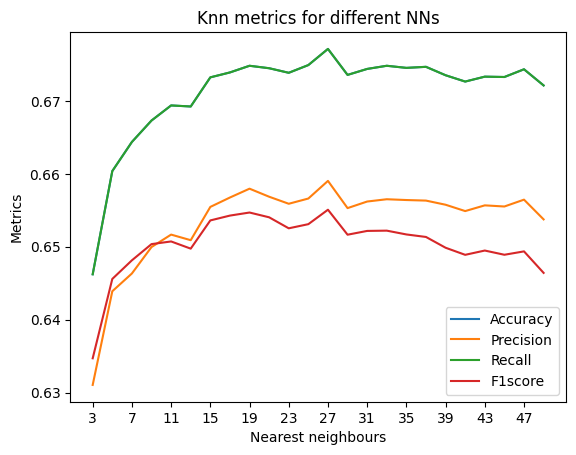

In [44]:
#Visualisation des resultats de KNN
with open("/content/results_knn.json", 'r') as json_file:
    result=json.load(json_file)

    x=[i for i in range(3,51,2)]
    y1_knn=[]
    y2_knn=[]
    y3_knn=[]
    y4_knn=[]

    for i in range (0,len(x),1) :
      y1_knn.append(result['knn'][i]["n"][str((i+1)*2+1)]["Accuracy"])
      y2_knn.append(result['knn'][i]["n"][str((i+1)*2+1)]["precision"])
      y3_knn.append(result['knn'][i]["n"][str((i+1)*2+1)]["recall"])
      y4_knn.append(result['knn'][i]["n"][str((i+1)*2+1)]["f1score"])


    plt.plot(x, y1_knn, label='Accuracy')
    plt.plot(x, y2_knn, label='Precision')
    plt.plot(x, y3_knn, label='Recall')
    plt.plot(x, y4_knn, label='F1score')

    plt.xlabel('Nearest neighbours')
    plt.ylabel('Metrics')

    plt.xticks(range(min(x), max(x)+1, 4))

    plt.legend(loc='lower right')

    plt.title('Knn metrics for different NNs')

    plt.show()

    json_file.close()

### **Interpretations :**
- Nous pouvons voir que les les résultats des métriques augmentent avec l'augmentation du nombre des voisins, jusqu'à ce que n=27, où les resultats de nos métriques se stabilisent (Overfitting).

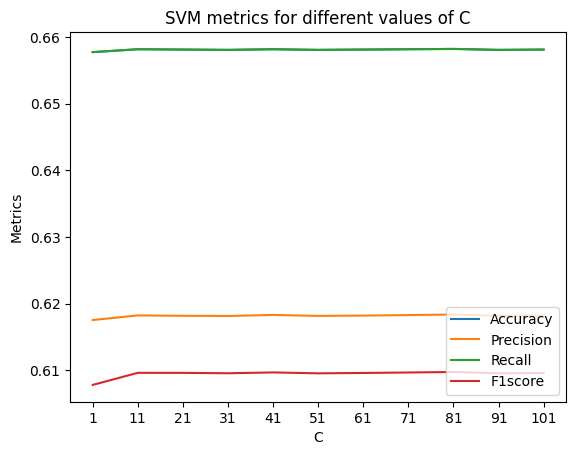

In [45]:
#Visualisation des resultats de SVM
with open("/content/results_svm.json", 'r') as json_file:
    result=json.load(json_file)

    x=[i for i in range(1,110,10)]
    y1_svm=[]
    y2_svm=[]
    y3_svm=[]
    y4_svm=[]

    for i in range (0,len(x),1) :
      y1_svm.append(result['svm'][i]["c"][str(i*10+1)]["Accuracy"])
      y2_svm.append(result['svm'][i]["c"][str(i*10+1)]["precision"])
      y3_svm.append(result['svm'][i]["c"][str(i*10+1)]["recall"])
      y4_svm.append(result['svm'][i]["c"][str(i*10+1)]["f1score"])


    plt.plot(x, y1_svm, label='Accuracy')
    plt.plot(x, y2_svm, label='Precision')
    plt.plot(x, y3_svm, label='Recall')
    plt.plot(x, y4_svm, label='F1score')

    plt.xlabel('C')
    plt.ylabel('Metrics')

    plt.xticks(range(min(x), max(x)+1, 10))

    plt.legend(loc='lower right')

    plt.title('SVM metrics for different values of C')
    plt.show()

    json_file.close()

### **Interpretations :**
- Nous pouvons voir que les les résultats des métriques sont statique pour n'importe quel valeur de c.

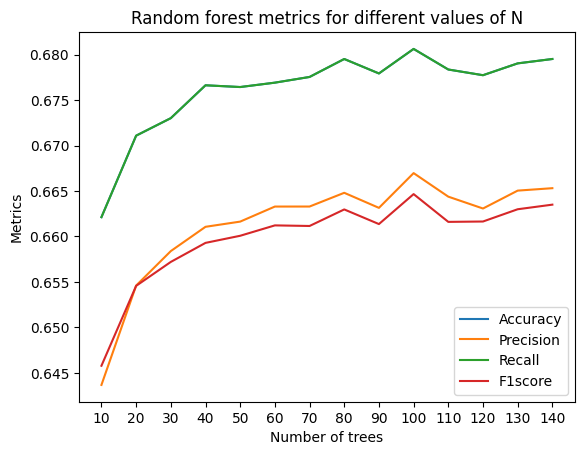

In [46]:
#Visualisation des resultats de Random Forest
with open("/content/results_rf.json", 'r') as json_file:
    result=json.load(json_file)

    x=[i for i in range(10,150,10)]
    y1_rf=[]
    y2_rf=[]
    y3_rf=[]
    y4_rf=[]

    for i in range (0,len(x),1) :
      y1_rf.append(result['random forest'][i]["n"][str((i+1)*10)]["Accuracy"])
      y2_rf.append(result['random forest'][i]["n"][str((i+1)*10)]["precision"])
      y3_rf.append(result['random forest'][i]["n"][str((i+1)*10)]["recall"])
      y4_rf.append(result['random forest'][i]["n"][str((i+1)*10)]["f1score"])


    plt.plot(x, y1_rf, label='Accuracy')
    plt.plot(x, y2_rf, label='Precision')
    plt.plot(x, y3_rf, label='Recall')
    plt.plot(x, y4_rf, label='F1score')

    plt.xlabel('Number of trees')
    plt.ylabel('Metrics')

    plt.xticks(range(min(x), max(x)+1, 10))

    plt.legend(loc='lower right')

    plt.title('Random forest metrics for different values of N')
    plt.show()

    json_file.close()

### **Interpretations :**
- Nous pouvons voir que les les résultats des métriques augmentent avec l'augmentation du nombre des arbres dans le modèle, jusqu'à ce que n=90, où les resultats de nos métriques se stabilisent (Overfitting).

In [47]:
#comparaison des resultats maximums des métriques entre les différents modèles

data = {
    'Knn': [max(y1_knn,key=lambda x:float(x)),
            max(y2_knn,key=lambda x:float(x)),
            max(y3_knn,key=lambda x:float(x)),
            max(y4_knn,key=lambda x:float(x))],

    'SVM': [max(y1_svm,key=lambda x:float(x)),
            max(y2_svm,key=lambda x:float(x)),
            max(y3_svm,key=lambda x:float(x)),
            max(y4_svm,key=lambda x:float(x))],

    'Naive Bayes' : [accuracy_nb,precision_nb,recall_nb,fscore_nb],

    'Random Forest': [max(y1_rf,key=lambda x:float(x)),
            max(y2_rf,key=lambda x:float(x)),
            max(y3_rf,key=lambda x:float(x)),
            max(y4_rf,key=lambda x:float(x))]
}

df = pd.DataFrame(data, index=['Accuracy','Precision','Recall','F1score'])
df=df.T
print(df)

               Accuracy  Precision    Recall   F1score
Knn            0.677152   0.659042  0.677152  0.655085
SVM            0.658221   0.618351  0.658221  0.609726
Naive Bayes    0.586396   0.496403  0.586396  0.437509
Random Forest  0.680620   0.666966  0.680620  0.664657


### **Interpretations :**
- D'après le tableau ci-dessous, les meilleurs modèle sont le Random Forest, suivi par KNN. Le Random Forest donne de bonne résultats car il n'est pas affecté par le probléme du désequilibre des classes.
- Le modèle SVM donne des résultats statique maisassez satisfaisant.Le modèle Naive Bayes donne les résultats les plus mauvais résultats.